In [1]:
from google.colab import files
uploaded = files.upload()

Saving Signature_data.zip to Signature_data.zip


In [ ]:
!unzip Signature_data.zip

Due to memory constraints we are only Working on the Hindi Signatures


In [3]:
import os
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, ZeroPadding2D, Flatten
from tqdm import tqdm
import shutil
import random
from PIL import Image
from tensorflow.keras.layers import Lambda
from tensorflow.keras import metrics
from keras.callbacks import EarlyStopping
import pickle
from keras.models import Sequential

<h3> Merging all Images into one file </h3>

In [ ]:
FolderPath = "BHSig260-Hindi/"
!mkdir "Training_Data/"
!mkdir "Testing_Data"
!mkdir "AllImages/"

In [ ]:
destination_folder = "AllImages/"
label_folder = os.listdir(FolderPath)
for folder in tqdm(label_folder):
    folder = os.path.join(FolderPath, folder)
    for files in os.listdir(folder):
        # Create the full paths to the source and destination files
        source_file_path = os.path.join(folder, files)
        destination_file_path = os.path.join(destination_folder, files)
        shutil.copy(source_file_path, destination_file_path)

I have merged all the data from hindi signature folders into one folder

<h3> 80% Training and 20% Testing Data </h3>

<p> I have randomly sampled 80% of data from all images into training folder</p>
<p> The rest 20% are placed into testing folder </p>

In [4]:
# source_folder = "AllImages/"
Train_data = "Signature_data/Training_Data/"
Test_data = "Signature_data/Testing_Data/"

In [ ]:
def move_files_randomly(Train_data, source_folder, percentage):
    # List all files in the source folder
    files = os.listdir(source_folder)
    # Calculate the number of files to move based on the specified percentage
    num_files_to_move = int(len(files) * percentage)
    # Randomly select files to move
    files_to_move = random.sample(files, num_files_to_move)

    for file in tqdm(files_to_move):
        source_file_path = os.path.join(source_folder, file)
        dest_file_path = os.path.join(Train_data, file)
        shutil.move(source_file_path, dest_file_path)

move_files_randomly(Train_data, source_folder, 0.8)
move_files_randomly(Test_data, source_folder, 1)

<h3> Training </h3>

In [5]:
def mapping_to_dict(folder_path):
    dict_map = {}
    flag = False
    files = os.listdir(folder_path)
    for file in tqdm(files):
        label = file.split("-")[2]
        authentic = file.split("-")[3]
        key = (label, authentic)

        if key not in dict_map:
            dict_map[key] = [file]
        else:
            dict_map[key].append(file)
    return dict_map

I have created a dictionary where the key is the class label + the authentic tag, the value represents a list of image names belonging to this class.
The same process is being repeated for testing data

In [6]:
train_dict = mapping_to_dict(Train_data)
test_dict = mapping_to_dict(Test_data)

100%|██████████| 1724/1724 [00:00<00:00, 555460.14it/s]


In [7]:
len(test_dict), len(train_dict)

(318, 319)

Example Showing the structure of train dictionaries. A similar pattern is being followed for test dictionaries

In [8]:
test_dict['144', 'G']

['H-S-144-G-07.tif',
 'H-S-144-G-08.tif',
 'H-S-144-G-04.tif',
 'H-S-144-G-23.tif']

The Train and test dict contains the labels and authencity of files in one group. </br> We will group a particular person's signature with their corresponding label. Person+label will be used as key here.

<h3> Preprocessing Data before Model training </h3>

Preprocess image scales every image by 255. I have also resized the image so that every image will have exactly the same dimensions

In [9]:
def preprocess_image(img):
    image = Image.open(img)
    image = image.resize((320, 90))
    image = np.array(image)
    image = image / 255.0
    image = np.expand_dims(image, axis = -1)
    return image

In [10]:
def return_curr_image(value, folder_path):
    image_path = os.path.join(folder_path, value)
    image = preprocess_image(image_path)
    return image

In [11]:
def select_another_genuine(values, folder_path):
    random_index = random.randint(0, len(values) - 1)
    image = os.path.join(folder_path, values[random_index])
    image = preprocess_image(image)
    return image

In [12]:
def select_fake_image(key, train_dict, Train_data):
    fake_key = [key[0]]
    fake_key.append('F')
    fake_key = tuple(fake_key)
    image  = select_another_genuine(train_dict[fake_key], Train_data)
    return image

In [13]:
def image_pairs(train_dict, Train_data):
    label_pairs = []
    image_pairs = []
    for key in tqdm(train_dict):
      if key[1] == 'G':
        for value in train_dict[key]:
          label_pairs.append([1])
          currImage = return_curr_image(value, Train_data)
          genuine_image = select_another_genuine(train_dict[key], Train_data)
          image_pairs.append([currImage, genuine_image])
          fake_image = select_fake_image(key, train_dict, Train_data)
          image_pairs.append([currImage, fake_image])
          label_pairs.append([0])

    return (np.array(image_pairs), np.array(label_pairs))

In [14]:
test_dict[('34', 'F')]

['H-S-34-F-16.tif', 'H-S-34-F-09.tif', 'H-S-34-F-25.tif', 'H-S-34-F-17.tif']

<h4> Creating training and testing pairs </h4>

In [15]:
(training_pairs, training_labels) = image_pairs(train_dict, Train_data)

100%|██████████| 319/319 [00:34<00:00,  9.16it/s]


In [16]:
(testing_pairs, testing_labels) = image_pairs(test_dict, Test_data)

100%|██████████| 318/318 [00:06<00:00, 50.70it/s]


In [17]:
training_pairs.shape, testing_pairs.shape

((6128, 2, 90, 320, 1), (1504, 2, 90, 320, 1))

The idea here is to pick two images which are genuine, give them a particular label and then pick two images one of which is genuine and the other is fake, give them a label(different from the previous one) and train them.
This type of network is known as **Siamese network**

<h3> Siamese Model </h3>

In [18]:
def euclidean_distance(vecs):
    (imgA, imgB) = vecs
    ss = K.sum(K.square(imgA - imgB), axis = 1, keepdims=True)
    return K.sqrt(K.maximum(ss, K.epsilon()))

<p>The loss function used in Siamese network is known as contrastive loss.</p>
<p>Let Euc_dist = euclidean distance</br>
Y = label given(0 or 1)</br>
Contrastive Loss = Y * (Euc_dist)^2 + (1-Y) * max((1-Euc_dist , 0)^2)</p>


In [19]:
def contrastiveLoss(y, y_preds, margin=1):
    y = tf.cast(y, y_preds.dtype)
    y_preds_squared = K.square(y_preds)
    margin_squared = K.square(K.maximum(margin - y_preds, 0))
    loss = K.mean(y * y_preds_squared + (1 - y) * margin_squared)
    return loss

I am trying to compare Three siamese models here. The first one is a complex one while the second one is a bit moderate and the third one is a simple NN.


In [20]:
def siamese_model(input_shape):

  seq = Sequential()
  seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape))
  seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
  seq.add(MaxPooling2D((3,3), strides=(2, 2)))
  seq.add(ZeroPadding2D((2, 2)))

  seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1))
  seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
  seq.add(MaxPooling2D((3,3), strides=(2, 2)))
  seq.add(Dropout(0.3))# added extra
  seq.add(ZeroPadding2D((1, 1)))

  seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1))
  seq.add(ZeroPadding2D((1, 1)))

  seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1))
  seq.add(MaxPooling2D((3,3), strides=(2, 2)))
  seq.add(Dropout(0.3))# added extra
  seq.add(Flatten(name='flatten'))
  seq.add(Dense(1024,  activation='relu'))
  seq.add(Dropout(0.5))

  seq.add(Dense(128, activation='relu')) # softmax changed to relu

  return seq

In [21]:
def siamese_model_2(input_shape, embeddingDim = 32):
    inputs = Input(input_shape)
    x = Conv2D(8, (5, 5), padding = "same", activation = "relu")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(16, (3, 3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(32, (3, 3), padding = "same",  activation = "relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), padding = "same",  activation = "relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    pooling = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooling)
    model = Model(inputs, outputs)
    return model

In [22]:
def siamese_model_3(input_shape, embeddingDim = 32):
    inputs = Input(input_shape)
    x = Conv2D(32, (5, 5), padding = "same", activation = "relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding = "same",  activation = "relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.23)(x)

    pooling = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooling)
    model = Model(inputs, outputs)
    return model

In [23]:
image_shape = (90,320,1)
# specify the batch size and number of epochs
batch_size = 32
epochs = 5
imageA = Input(shape = image_shape)
imageB = Input(shape = image_shape)

In [24]:
model_build = siamese_model(image_shape)
modelA = model_build(imageA)
modelB = model_build(imageB)
distance = Lambda(euclidean_distance)([modelA, modelB])
model_siamese_1 = Model(inputs=[imageA, imageB], outputs=distance)

I have used Accuracy and Precision as the performing metrics for evaluating the model's performance

In [25]:
model_siamese_1.compile(loss = contrastiveLoss, optimizer="adam", metrics=['accuracy', metrics.Precision()])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
history = model_siamese_1.fit(
    [training_pairs[:, 0], training_pairs[:, 1]], training_labels[:],
    validation_data=([testing_pairs[:, 0], testing_pairs[:, 1]], testing_labels[:]),
    batch_size = batch_size,
    epochs = epochs, callbacks=[early_stopping])

Epoch 1/5
192/192 [==============================] - 827s 4s/step - loss: 1.4822 - accuracy: 0.4949 - precision: 0.4943 - val_loss: 0.4960 - val_accuracy: 0.5000 - val_precision: 0.0000e+00
Epoch 2/5
192/192 [==============================] - 836s 4s/step - loss: 0.2726 - accuracy: 0.4972 - precision: 0.4966 - val_loss: 0.4985 - val_accuracy: 0.5000 - val_precision: 0.0000e+00
Epoch 3/5
192/192 [==============================] - 830s 4s/step - loss: 0.2691 - accuracy: 0.5075 - precision: 0.5092 - val_loss: 0.4977 - val_accuracy: 0.5000 - val_precision: 0.0000e+00
Epoch 3: early stopping


<h3> Points to be noted </h3>
1. The first model highly overfits our training data. </br>
2. While the training loss is steadily decreasing, there is no difference in the validation loss.</br>
3. This model overall performs very poorly on our dataset,

In [26]:
pairs = np.random.choice(len(testing_pairs), size=4)

In [28]:
for i in pairs:
  label = testing_labels[i]
  print(label)

[0]
[0]
[0]
[1]


1/1 [==============================] - 0s 490ms/step


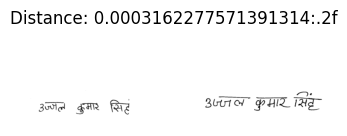

1/1 [==============================] - 0s 64ms/step


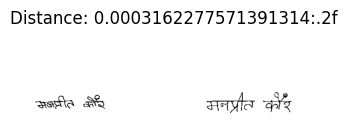

1/1 [==============================] - 0s 64ms/step


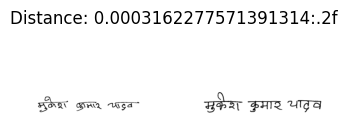

1/1 [==============================] - 0s 76ms/step


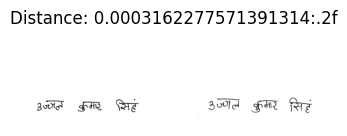

In [29]:
for i in pairs:
  imageA = testing_pairs[i][0]
  imageB = testing_pairs[i][1]
  label = testing_labels[i]

  baseA = imageA.copy()
  baseB = imageB.copy()
  imageA = np.expand_dims(imageA, axis=0)
  imageB = np.expand_dims(imageB, axis =0)

  imageA = imageA/255.0
  imageB = imageB/255.0
  predicts = model_siamese_1.predict([imageA, imageB])
  proba = predicts[0][0]
  fig = plt.figure("Pair".format(i+1), figsize=(4,2))
  plt.suptitle("Distance: {}:.2f".format(proba))
  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(baseA, cmap=plt.cm.gray)
  plt.axis("off")
  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(baseB, cmap=plt.cm.gray)
  plt.axis("off")
  plt.show()

<h3> Conclusion </h3>
<p> The difference in euclidean distance between true and false labels are non existent.</BR>
For every image pair the output distance is more or less the same.


<h3> Training siamese model 2 </h3>

<p> One of the main reasons of overfitting is model complexity. I have used a relatively simpler architecture as compared to the first model

In [31]:
image_shape = (90,320,1)
# specify the batch size and number of epochs
batch_size = 32
epochs = 5
imageA = Input(shape = image_shape)
imageB = Input(shape = image_shape)

In [32]:
model_build = siamese_model_2(image_shape)
modelA = model_build(imageA)
modelB = model_build(imageB)
distance = Lambda(euclidean_distance)([modelA, modelB])
model_siamese_2 = Model(inputs=[imageA, imageB], outputs=distance)

In [33]:
model_siamese_2.compile(loss = contrastiveLoss, optimizer="adam", metrics=['accuracy', metrics.Precision()])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
history = model_siamese_2.fit(
    [training_pairs[:, 0], training_pairs[:, 1]], training_labels[:],
    validation_data=([testing_pairs[:, 0], testing_pairs[:, 1]], testing_labels[:]),
    batch_size = batch_size,
    epochs = epochs, callbacks=[early_stopping])

Epoch 1/5
192/192 [==============================] - 385s 2s/step - loss: 0.3420 - accuracy: 0.4783 - precision_1: 0.4882 - val_loss: 0.3136 - val_accuracy: 0.4914 - val_precision_1: 0.0000e+00
Epoch 2/5
192/192 [==============================] - 384s 2s/step - loss: 0.2265 - accuracy: 0.3996 - precision_1: 0.4295 - val_loss: 0.2155 - val_accuracy: 0.3730 - val_precision_1: 0.0103
Epoch 3/5
192/192 [==============================] - 381s 2s/step - loss: 0.1992 - accuracy: 0.3117 - precision_1: 0.3375 - val_loss: 0.1896 - val_accuracy: 0.3251 - val_precision_1: 0.0148
Epoch 4/5
192/192 [==============================] - 361s 2s/step - loss: 0.1714 - accuracy: 0.2363 - precision_1: 0.2486 - val_loss: 0.1586 - val_accuracy: 0.2453 - val_precision_1: 0.0201
Epoch 5/5
192/192 [==============================] - 398s 2s/step - loss: 0.1546 - accuracy: 0.2066 - precision_1: 0.1971 - val_loss: 0.1492 - val_accuracy: 0.2367 - val_precision_1: 0.0308


<h2> Points to be noted </h2>
1. The model performs well here. </br>
2. With respect to the training loss, there is a steady decrease in the validation loss as well </br>

In [37]:
pairs = np.random.choice(len(testing_pairs), size=4)

In [38]:
for i in pairs:
  label = testing_labels[i]
  print(label)

[1]
[0]
[0]
[1]


1/1 [==============================] - 0s 36ms/step


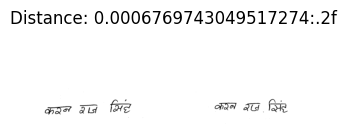

1/1 [==============================] - 0s 46ms/step


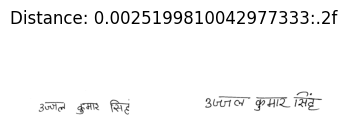

1/1 [==============================] - 0s 49ms/step


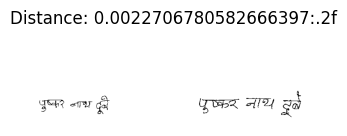

1/1 [==============================] - 0s 48ms/step


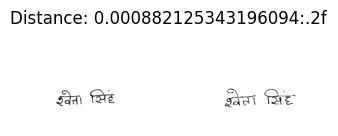

In [39]:
for i in pairs:
  imageA = testing_pairs[i][0]
  imageB = testing_pairs[i][1]
  label = testing_labels[i]

  baseA = imageA.copy()
  baseB = imageB.copy()
  imageA = np.expand_dims(imageA, axis=0)
  imageB = np.expand_dims(imageB, axis =0)

  imageA = imageA/255.0
  imageB = imageB/255.0
  predicts = model_siamese_2.predict([imageA, imageB])
  proba = predicts[0][0]
  fig = plt.figure("Pair".format(i+1), figsize=(4,2))
  plt.suptitle("Distance: {}:.2f".format(proba))
  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(baseA, cmap=plt.cm.gray)
  plt.axis("off")
  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(baseB, cmap=plt.cm.gray)
  plt.axis("off")
  plt.show()

<H3> Conclusion <h3>
<p> We can see here that the distance between the true labels is much less than the false labels.
<P> Due to Memory constraints I was only able to train my model for 5 epochs. Colab notebook was crashing with the increase in the epoch size.</BR>
With more number of epochs the model's performance would have definitey increased.

  Training siamese model 3

<p> The idea behind this architecture was to make the arhcitecture even more simpler than the first and second model </p>

In [40]:
image_shape = (90,320,1)
# specify the batch size and number of epochs
batch_size = 32
epochs = 5
imageA = Input(shape = image_shape)
imageB = Input(shape = image_shape)

In [41]:
model_build = siamese_model_3(image_shape)
modelA = model_build(imageA)
modelB = model_build(imageB)
distance = Lambda(euclidean_distance)([modelA, modelB])
model_siamese_3 = Model(inputs=[imageA, imageB], outputs=distance)

In [42]:
model_siamese_3.compile(loss = contrastiveLoss, optimizer="adam", metrics=['accuracy', metrics.Precision()])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
history = model_siamese_3.fit(
    [training_pairs[:, 0], training_pairs[:, 1]], training_labels[:],
    validation_data=([testing_pairs[:, 0], testing_pairs[:, 1]], testing_labels[:]),
    batch_size = batch_size,
    epochs = epochs, callbacks=[early_stopping])

Epoch 1/5
192/192 [==============================] - 686s 4s/step - loss: 0.1866 - accuracy: 0.2839 - precision_2: 0.1949 - val_loss: 0.3668 - val_accuracy: 0.5000 - val_precision_2: 0.0000e+00
Epoch 2/5
192/192 [==============================] - 672s 3s/step - loss: 0.1333 - accuracy: 0.1681 - precision_2: 0.1315 - val_loss: 0.1776 - val_accuracy: 0.3012 - val_precision_2: 0.0372
Epoch 3/5
192/192 [==============================] - 665s 3s/step - loss: 0.1218 - accuracy: 0.1482 - precision_2: 0.1252 - val_loss: 0.1258 - val_accuracy: 0.1895 - val_precision_2: 0.0501
Epoch 4/5
192/192 [==============================] - 655s 3s/step - loss: 0.1184 - accuracy: 0.1446 - precision_2: 0.1157 - val_loss: 0.1256 - val_accuracy: 0.1922 - val_precision_2: 0.0398
Epoch 5/5
192/192 [==============================] - 640s 3s/step - loss: 0.1136 - accuracy: 0.1400 - precision_2: 0.1210 - val_loss: 0.1563 - val_accuracy: 0.2719 - val_precision_2: 0.0377


<h2> Points to be noted </h2>
1. The model performs well here. </br>
2. With respect to the training loss, there is a steady decrease in the validation loss as well </br>

Testing our model

In [43]:
pairs = np.random.choice(len(testing_pairs), size=4)

In [44]:
for i in pairs:
  label = testing_labels[i]
  print(label)

[1]
[1]
[1]
[0]


1/1 [==============================] - 0s 147ms/step


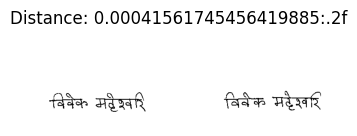

1/1 [==============================] - 0s 52ms/step


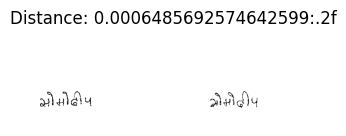

1/1 [==============================] - 0s 52ms/step


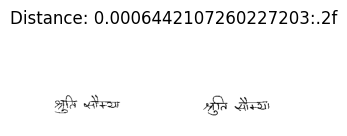

1/1 [==============================] - 0s 57ms/step


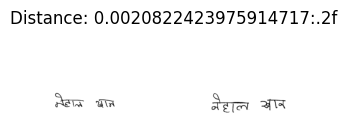

In [45]:
for i in pairs:
  imageA = testing_pairs[i][0]
  imageB = testing_pairs[i][1]
  label = testing_labels[i]

  baseA = imageA.copy()
  baseB = imageB.copy()
  imageA = np.expand_dims(imageA, axis=0)
  imageB = np.expand_dims(imageB, axis =0)

  imageA = imageA/255.0
  imageB = imageB/255.0
  predicts = model_siamese_3.predict([imageA, imageB])
  proba = predicts[0][0]
  fig = plt.figure("Pair".format(i+1), figsize=(4,2))
  plt.suptitle("Distance: {}:.2f".format(proba))
  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(baseA, cmap=plt.cm.gray)
  plt.axis("off")
  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(baseB, cmap=plt.cm.gray)
  plt.axis("off")
  plt.show()

<H3> Conclusion <h3>
<p> We can see here that the distance between the true labels is much less than the false labels.
<P> Due to Memory constraints I was only able to train my model for 5 epochs. Colab notebook was crashing with the increase in the epoch size.</BR>
With more number of epochs the model's performance would have definitey increased.

<h4> Kindly note that this assignment was done with the limitations of my Computers Memory.
We can achieve drastically greater results with increasing the epoch size of model 2 and model 3(EPOCH Size of 100 would be best)</h4>

<h4> I was unable to run my model's prediction on the testing data due to memory constraints. However after every model's training i have ploted some of the testing data along with their labels for demonstrating the model's performance </h4>